# Demonstration of the experiment for reproducibility
## Gabor scattering vs. Gabor transform comparison on synthetic dataset

Article: "Gabor frames and deep scattering networks in audio processing" <br> Authors: R. Bammer, M. Dörfler, P. Harar<br> Submitted to a special issue (Harmonic Analysis and Applications) of Axioms (ISSN 2075-1680)

# Summary
The task is a multi-class (4 classes) synthetic sound classification.

# Outline

1. Configuration of the experiment
1. Visualization of data with current configuration
1. Bulk visualization of all 4 classes side by side
1. Generating data and saving them to memmaps for training
1. Running the experiments on one or multiple GPUs
1. Evaluation of the experiments
1. Comparison of speed

In [1]:
from src.utils import Memmap_Sequence, make_data, load_memmap, dbplot
from src.sound_gen import generate_four_classes
from multiprocessing import Pool
import itertools
import subprocess
import time, os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
cmap = 'magma_r' # Inverted magma color map for figures that might be printed.
import pandas as pd
from IPython.display import Audio
import timeit
import multiprocessing
from gabor_scattering import gs

Using TensorFlow backend.


# Configuration of the experiment

In [2]:
paths = {
    # This is a folder, where generated data will be stored. Ideally should be on SSD
    'path_to_generated_data': 'data',
}

In [3]:
exp_params = {
    'config_index': '07', # Config id: C07
    'train_seed': 10,
    'valid_seed': 99,
    'validate_on_nsamples': 20000, # For all 4 classes together
    'batch_size': 100,
    'weight_updates': 2000, # Will be mapped to number of epochs based on train size
    'scaling_func': 'identity', # Identity means, no scaling is done
    'dense_l2_regularization': 0.001, # Weight regularization
}

sample_params = {
    'dur': 1, # In seconds
    'rate': 44100 # In Hz
}

tfparams = {
    'GS': {
        'l1_params' : {'nfft': 500, 'nperseg': 500, 'noverlap': 250},
        'l2_params' : {'nfft': 50, 'nperseg': 50, 'noverlap': 40},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (240, 160), 'outB': (240, 160), 'outC': (240, 160)},

    },
    'GT': {
        'l1_params' : {'nfft': 500, 'nperseg': 500, 'noverlap': 250},
        'shapes' : {'outA': (240, 160)},
        'return_outB': False,
        'return_outC': False,
    },
}

# Output shapes of each tf represenatation
# We need to know the shapes to be able to save the memorymaps
memmap_shapes = {
    'GS': (3,240,160),
    'GT': (240,160),
}


generator_kwargs = {
    **sample_params,
    'nharmonics':5, # Including fundamental frequency
    'tfparams': tfparams,
    'yield_wave': True,
    'yield_params': True,
    'memmap_shapes': memmap_shapes
}

# Visualize some of the data generated with current config

## Detailed visualization - one sample at a time

In [4]:
# Initialize the temporary generator
temp_gen_kwargs = generator_kwargs.copy()
temp_gen_kwargs.update({'start_i': 0, 'stop_i': None, 'seed': exp_params['train_seed']})
generator = generate_four_classes(**temp_gen_kwargs)
print('Generator initialized. Run this code again if you want to restart it.')

Generator initialized. Run this code again if you want to restart it.


In [8]:
# Call the generator to get a sample (next call = next sample in order set by seed)
output = next(generator)
print('Generated sample with id {} from class {}'.format(output['i'], output['nclass']))

Generated sample with id 0 from class 3


In [9]:
# Display the parameters that generated this sample
# index 0 is the fundamental sine wave, others are harmonics
pd.DataFrame(output['params'])

a  a_am  a_fm     f  f_am  f_fm         p      p_am      p_fm
0  1.000000     1     1  1389  4.25    25  1.877172  0.158159  3.981329
1  0.769231     1     1  2778  4.25    25  1.877172  0.158159  3.981329
2  0.591716     1     1  4167  4.25    25  1.877172  0.158159  3.981329
3  0.455166     1     1  5556  4.25    25  1.877172  0.158159  3.981329
4  0.350128     1     1  6945  4.25    25  1.877172  0.158159  3.981329

In [10]:
# Play the audio
Audio(output['wave'], rate=sample_params['rate'])

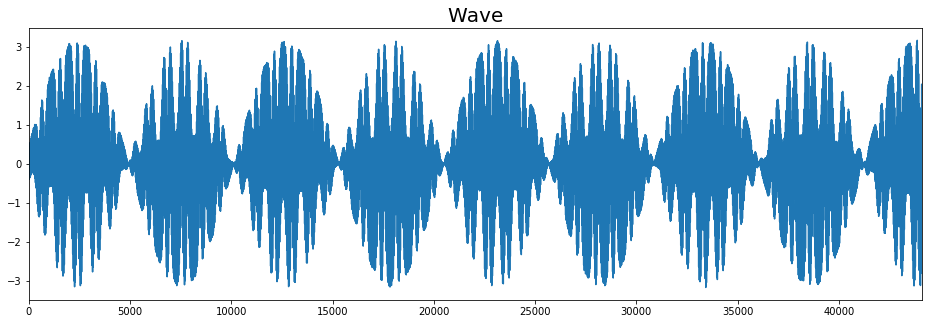

In [11]:
# Visualization of the raw wave
plt.figure(figsize=(16,5))
plt.title('Wave', fontsize=20)
plt.xlim(0, sample_params['rate'] * sample_params['dur'])
plt.plot(output['wave']); plt.show(); plt.close()

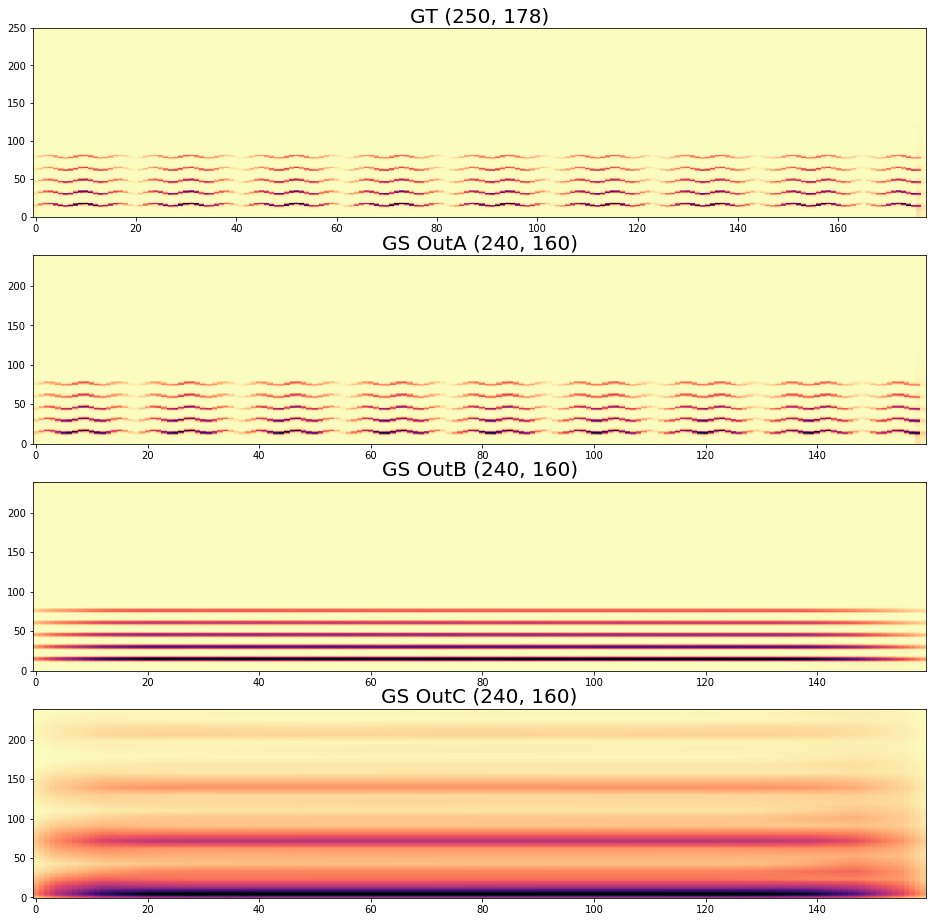

In [12]:
GS = gs(output['wave'], return_layer1=True, **tfparams['GS']) 

plt.figure(figsize=(16,16))
plt.subplot(4,1,1)
plt.title('GT {}'.format(GS['layer1'].shape), fontsize=20)
plt.imshow(GS['layer1'], aspect='auto', origin='lower', cmap=cmap)

plt.subplot(4,1,2)
plt.title('GS OutA {}'.format(GS['outA'].shape), fontsize=20)
plt.imshow(GS['outA'], aspect='auto', origin='lower', cmap=cmap)

plt.subplot(4,1,3)
plt.title('GS OutB {}'.format(GS['outB'].shape), fontsize=20)
plt.imshow(GS['outB'], aspect='auto', origin='lower', cmap=cmap)

plt.subplot(4,1,4)
plt.title('GS OutC {}'.format(GS['outC'].shape), fontsize=20)
plt.imshow(GS['outC'], aspect='auto', origin='lower', cmap=cmap)

plt.show(); plt.close()

## Bulk visualization - all 4 classes at the same time

In [13]:
# Initialize new temporary generator
temp_gen_kwargs = generator_kwargs.copy()
temp_gen_kwargs.update({'start_i': 12, 'stop_i': None, 'seed': exp_params['train_seed']})
generator = generate_four_classes(**temp_gen_kwargs)
print('Generator initialized. Run this code again if you want to restart it.')

Generator initialized. Run this code again if you want to restart it.


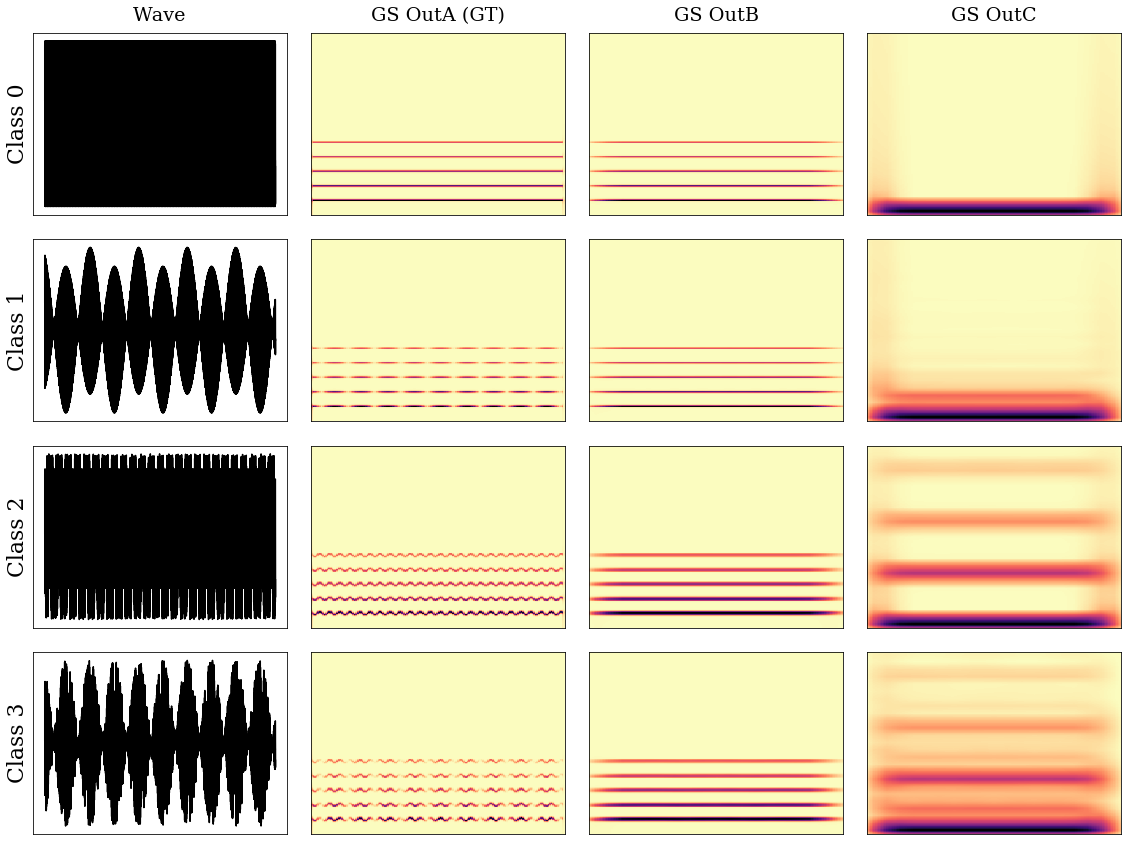

In [15]:
# Construct grid subplot
plt.figure(figsize=(16,12))
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"
plt.rcParams.update({'font.size': 16})

index = 1
for i in range(4):
    
    # Remove the axis labels
    tick_params = {'axis': 'both', 'bottom': False, 'left': False, 'labelleft': False, 'labelbottom': False}
    
    # Get all representation of a sample
    output = next(generator)
    
    # Plot wave
    plt.subplot(4,4,index)
    plt.tick_params(**tick_params) 
    if i == 0: plt.title('Wave', y=1.03)
    plt.ylabel('Class {}'.format(i), fontsize=22)
    plt.plot(output['wave'], color='black')
    index += 1
    
    # Plot GS OutA
    plt.subplot(4,4,index)
    plt.tick_params(**tick_params)
    if i == 0: plt.title('GS OutA (GT)', y=1.03)
    plt.imshow(output['GS'][0], aspect='auto', origin='lower', cmap=cmap)
    index += 1
    
    # Plot GS OutB
    plt.subplot(4,4,index)
    plt.tick_params(**tick_params)
    if i == 0: plt.title('GS OutB', y=1.03)
    plt.imshow(output['GS'][1], aspect='auto', origin='lower', cmap=cmap)
    index += 1
    
    # Plot GS OutC (with dbplot)
    plt.subplot(4,4,index)
    plt.tick_params(**tick_params)
    if i == 0: plt.title('GS OutC', y=1.03)
    plt.imshow(output['GS'][2], aspect='auto', origin='lower', cmap=cmap)
    index += 1
    
plt.tight_layout()
plt.savefig('experiments/visualization.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Generate data and save to disk

In [16]:
# Saves generated data to specified path (example: path/train/seed-Cxx)
# Will generate 'stop_i' samples per class
# To speed up the process the multiprocessing is used
# Takes about 40 minutes on 16 physical core CPU with 16 processes 
# using chunksize 100 to generate 'stop_i': 10000

st1 = time.time()

# Create training data
gk = generator_kwargs.copy()
gk.update({'start_i': 0, 'stop_i': 2500, 'seed': exp_params['train_seed']})
make_data(gk, 'train', paths['path_to_generated_data'], exp_params['config_index'], chunksize=100, processes=16)
st2 = time.time()
print('Train data gen time: {:.4f} minutes.'.format((st2 - st1)/60))

# Create validation data
gk = generator_kwargs.copy()
gk.update({'start_i': 0, 'stop_i': 5000, 'seed': exp_params['valid_seed']})
make_data(gk, 'valid', paths['path_to_generated_data'], exp_params['config_index'], chunksize=100, processes=16)
st3 = time.time()
print('Valid data gen time: {:.4f} minutes.'.format((st3 - st2)/60))

print('DONE. Total time: {:.4f} minutes.'.format((time.time() - st1)/60))

Initialized memmap: data/train/10-C07/memmap_GS_10000x115200.dat
Initialized memmap: data/train/10-C07/memmap_GT_10000x38400.dat
Started to fill the memmaps, please wait, it takes time...

Done generating data and filling memmaps.
Train data gen time: 1.5185 minutes.
Initialized memmap: data/valid/99-C07/memmap_GS_20000x115200.dat
Initialized memmap: data/valid/99-C07/memmap_GT_20000x38400.dat
Started to fill the memmaps, please wait, it takes time...

Done generating data and filling memmaps.
Valid data gen time: 2.9487 minutes.
DONE. Total time: 4.4671 minutes.


## Sanity check to see whether the memmaps hold the right data

In [17]:
# Listening to generated sound
testsound =  np.load(os.path.join(paths['path_to_generated_data'], 
                                  'train/10-C07/wavs/0_0_wave.npy'))
from IPython.display import Audio
Audio(testsound, rate=44100)

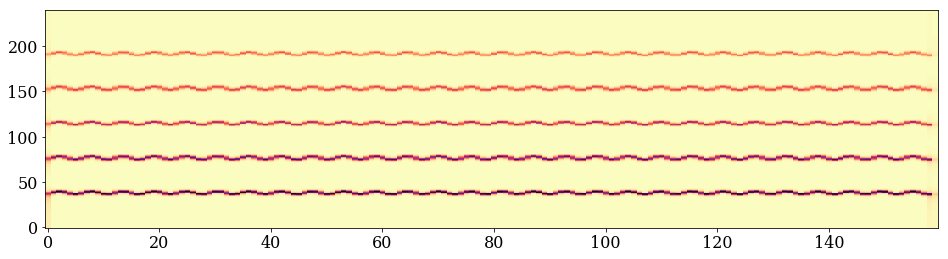

In [18]:
# Create a Memmap_Sequence that is used in training to obtain batches by their index
train_memmap = os.path.join(paths['path_to_generated_data'], 'train/10-C07/memmap_GT_10000x38400.dat')
train_seq_GT = Memmap_Sequence(train_memmap, 10000, 200, memmap_shapes['GT'])

# Visualize for example the 19th batch, X data, 33th sample, OUT_B
plt.figure(figsize=(16,4))
plt.imshow(train_seq_GT.__getitem__(19)[0][34], aspect='auto', origin='lower', cmap=cmap)
plt.show(); plt.close()

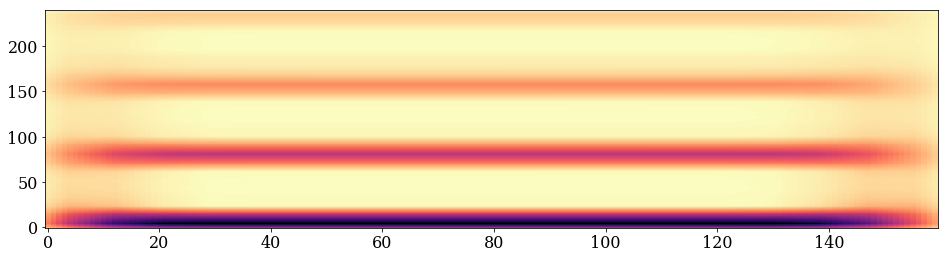

In [19]:
# Create a Memmap_Sequence that is used in training to obtain batches by their index
train_memmap = os.path.join(paths['path_to_generated_data'], 'train/10-C07/memmap_GS_10000x115200.dat')
train_seq_GS = Memmap_Sequence(train_memmap, 10000, 200, memmap_shapes['GS'])

# Visualize for example the 19th batch, X data, 32th sample, OUT_B
plt.figure(figsize=(16,4))
plt.imshow(train_seq_GS.__getitem__(19)[0][34][2], aspect='auto', origin='lower', cmap=cmap)
plt.show(); plt.close()

# Run the experiments in their own subprocess on one or more GPUs


For running the experimetns, we use a dedicated script *run-experiment.py* that runs the training.
Each slightly differ in neural network architecture, because of different input data.
Parameters are set using environment variables when calling the script.
______

To get a comparison of different time-frequency representations, we want to compare not only accuracy on all samples, but we also would like to see, if there is a difference in the speed of convergence with less data. Therefore we run multiple experiments, each with different number of training samples. We always validate using the same validation set of the same size. Training performance is evaluated accurately on the whole training set by a special callback, hence it is not the same averaged value as what Keras outputs as default.
______

Nowadays a lot of researchers have access to multiple GPU servers, therefore we prepared functions that run all of the models in parallel on all specified GPUs. A multiprocessing.Pool.starmap is used to bootstrap the *run-experiment.py* script on automatically selected GPU.

In [20]:
def run(env_vars, gpu_id_list, interpreter='python', script='run-experiment.py'):
    """
    This function is meant to be run by multiprocessing Pool. 
    It runs a bash command in a subprocess call. The command is build withn the 
    function by concatenatig the env_gpu, env_vars, interpreter and script.
    E.g.: 'CUDA_VISIBLE_DEVICES=0 EPOCHS=100 python run-experiment.py'
    
    This function automatically maps the CPU id of the current process to a GPU id 
    based on the gpu_id_list. The pool that calls this function must use exactly 
    as many processes as the len(gpu_id_list). Resulting in parallel run of multiple
    commands each on a unoccupied GPU. After the command finishes, the GPU is freed
    and it gets a new workload from the Pool.
    """
    
    # Get cpu id of current process
    cpu_name = multiprocessing.current_process().name
    cpu_id = int(cpu_name[cpu_name.find('-') + 1:]) - 1
    
    # Map cpu id to gpu id based on gpu_id_list
    gpu_id = gpu_id_list[cpu_id % len(gpu_id_list)]
    
    # Make the GPU visible for the script using env variable
    env_gpu = 'CUDA_VISIBLE_DEVICES={}'.format(gpu_id)
    
    # Call the command
    command = ' '.join([env_gpu, env_vars, interpreter, script])
    return_code = subprocess.call(command, shell=True)

    return (return_code, env_vars)


def manager(queue, gpu_id_list=[0], processes_per_gpu=4, allowed_restarts=3):
    """
    This function takes a queue of commands that run training on a GPU 
    and runs (len(gpu_id_list) / processes) number of commands on one of 
    the GPUs in gpu_id_list. If some subprocess dies, e.g. because
    of lack of the memory on a GPU, the error code gets recorded and the
    command will be called again in the next round until success.
    """
    st = time.time()
    # Keeps track of how many times the pipe was restarted
    # If it is too many times
    restart_counter = 0 
    while not len(queue) == 0:
        if restart_counter > 3:
            print('Restart counter reached its limit. Some of the models were not trained.')
            break
        
        # Running experiments in parallel on all available GPUs
        # If processes=len(gpu_id_list), all of the models should be trained at first go
        # If processes>len(gpu_id_list), the training process can take much less time, 
        # but it is necessary to use this while loop in order to pick up interrupted
        # processes and run them again. Setting processes to reasonable number
        # should lead to not many models to be interrupted. But it depends on lot of variables.
        with multiprocessing.Pool(processes=len(gpu_id_list) * processes_per_gpu) as pool:
            lq = len(queue)
            out = list(pool.starmap(run, zip(queue, itertools.repeat(gpu_id_list))))
            queue = [x for ret_code, x in out if ret_code != 0]
            print('Restarting {} interrupted models.'.format(len(queue)))
            if lq == len(queue):
                # In this case, the queue len did not change since the last run
                # so that might indicate models, that are not possible to run.
                # Keeping restart_counter to eventually kill the pipe no to loop
                # indifinetely.
                restart_counter += 1
            
    print('DONE. Total time: {:.4f} minutes.'.format((time.time() - st)/60))
    return queue

In [25]:
envs = ' '.join(
    [
        'PYTHONHASHSEED={}'.format(0),
        'CID={}'.format(exp_params['config_index']),
        'DATAPATH={}'.format(paths['path_to_generated_data']),
        'NVALID={}'.format(exp_params['validate_on_nsamples']),
        'TSEED={}'.format(exp_params['train_seed']),
        'VSEED={}'.format(exp_params['valid_seed']),
        'BATCHSIZE={}'.format(exp_params['batch_size']),
        'TMS0={}'.format(10000), # Train Memmap Shape 0
        'VMS0={}'.format(20000), # Valid Memmap Shape 0
        'SCALEF={}'.format(exp_params['scaling_func']), # one of {'identity', log'}
        'REG={}'.format(exp_params['dense_l2_regularization']),
    ])

# In order to spend equal amount of computational effort on each of the experiments
# here we specify for how many epochs it should run. The number of epochs is based
# on number of weight updates done throughout the whole training. One weight
# update is made after each batch. Here we limit the exps to 2000 weight updates.
# i.e. with train_size = 400, batch_size = 100, n_batches = 4, n_epochs = 500
# we obtain 500 * 4 = 2000 weight updates.

def get_n_epochs(ntrain, batch_size, weight_updates):
    return int(weight_updates / (ntrain / batch_size))

train_sizes = [400, 1000, 4000, 10000]

queue = []
for rep in list(tfparams.keys()):
    for i, ntrain in enumerate(train_sizes):
        specific_vars = 'EXPID={:02d} REP={} REPSHAPE="{}" NTRAIN={} EPOCHS={}'.format(
            i, rep, memmap_shapes[rep], ntrain, 
            get_n_epochs(ntrain, exp_params['batch_size'], exp_params['weight_updates']))
        queue.append(' '.join([envs, specific_vars]))
         
# List of the indices of available GPUs that should be used
gpu_id_list = [0, 1] # 0 = Titan, 1 = 1080Ti
manager(queue, gpu_id_list=gpu_id_list, processes_per_gpu=4, allowed_restarts=3)

Restarting 0 interrupted models.
DONE. Total time: 350.1425 minutes.


[]

In [ ]:
# # Run specific command from the queue outside the multiprocessing pipeline for debugging
# c = 'CUDA_VISIBLE_DEVICES=0 {} python run-experiment.py'.format(queue[0])
# !{c}

# Evaluate the experiments

In this step, we concatenate all training logs from all conducted experiments in one big table.
This table is later filtered to create plots of accuracy over number of weight updates for each of the train sizes. Output is saved also as a vector pdf into the experiment folder.

In [26]:
# Get the paths to log file of each experiment
logs = []
for root, dirs, files in os.walk('experiments'):
    for file in files:
        if '.csv' in file:
            logs.append(os.path.join(root, file))
            
logs_TF = [[f for f in logs if '{}_'.format(tf) in f] for tf in tfparams.keys()]

# Put the experiments results into Pandas DataFrame
dfs = []
for log in logs_TF:
    for l in log:
        df = pd.read_csv(l)
        expid, rep, configid, trainN, validN, epochN = l.split('/')[-2].replace('-', '_').split('_')
        df['rep'] = rep
        df['config'] = configid
        df['train_size'] = trainN[1:]
        df['valid_size'] = validN[1:]
        df['epochs'] = epochN[1:]
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.to_csv('experiments/all_results.csv', index=False, 
          columns=['config', 'rep', 'train_size', 'valid_size', 'epochs', 'epoch', 
                   'acc', 'loss', 'train_acc', 'train_loss', 'val_acc', 'val_loss'])
df

epoch    acc      loss  train_acc  train_loss  val_acc  val_loss rep  \
0         0  0.258  1.387621      0.250    1.368691  0.25000  1.368913  GS   
1         1  0.251  1.346866      0.273    1.314523  0.27590  1.316736  GS   
2         2  0.321  1.264492      0.440    1.180465  0.43580  1.185866  GS   
3         3  0.469  1.077939      0.464    0.930895  0.45710  0.943429  GS   
4         4  0.608  0.814208      0.780    0.679998  0.76530  0.690993  GS   
5         5  0.785  0.609059      0.805    0.552920  0.80650  0.554151  GS   
6         6  0.851  0.459937      0.883    0.395856  0.86340  0.415649  GS   
7         7  0.903  0.342390      0.935    0.295371  0.93445  0.296149  GS   
8         8  0.927  0.275212      0.931    0.251119  0.94050  0.249557  GS   
9         9  0.947  0.220888      0.956    0.176340  0.95775  0.175728  GS   
10       10  0.957  0.178522      0.950    0.154652  0.95200  0.159923  GS   
11       11  0.953  0.160359      0.955    0.134629  0.95830  0.140487  GS   
12       12  0.965  0.129235      0.962    0.121899  0.96345  0.125618  GS   
13       13  0.967  0.115198      0.970    0.103312  0.97295  0.104964  GS   
14       14  0.970  0.108225      0.962    0.120459  0.96360  0.132105  GS   
15       15  0.968  0.106208      0.959    0.113085  0.95775  0.129267  GS   
16       16  0.971  0.094987      0.965    0.095034  0.96680  0.107701  GS   
17       17  0.964  0.103808      0.981    0.113212  0.97950  0.114663  GS   
18       18  0.975  0.084910      0.983    0.073745  0.98265  0.079267  GS   
19       19  0.976  0.078867      0.967    0.112797  0.96500  0.135600  GS   
20       20  0.974  0.084762      0.973    0.076378  0.97185  0.093217  GS   
21       21  0.978  0.070335      0.980    0.064434  0.97790  0.076527  GS   
22       22  0.977  0.071664      0.986    0.056556  0.98325  0.071371  GS   
23       23  0.986  0.064252      0.984    0.057246  0.98335  0.075801  GS   
24       24  0.985  0.061036      0.990    0.052165  0.98370  0.066088  GS   
25       25  0.984  0.057785      0.989    0.050094  0.98315  0.067955  GS   
26       26  0.990  0.048998      0.990    0.046675  0.98625  0.060246  GS   
27       27  0.989  0.052312      0.987    0.044447  0.98480  0.062042  GS   
28       28  0.983  0.049005      0.988    0.045116  0.98425  0.060101  GS   
29       29  0.991  0.048552      0.990    0.043805  0.98535  0.065683  GS   
...     ...    ...       ...        ...         ...      ...       ...  ..   
1510    170  0.999  0.013136      0.999    0.013467  0.98825  0.055946  GT   
1511    171  0.999  0.011946      1.000    0.010714  0.99050  0.045325  GT   
1512    172  1.000  0.011701      1.000    0.011252  0.99070  0.047746  GT   
1513    173  0.999  0.013418      0.999    0.011631  0.99125  0.039662  GT   
1514    174  0.999  0.011994      0.999    0.010511  0.99075  0.045462  GT   
1515    175  1.000  0.010721      1.000    0.010605  0.99230  0.039421  GT   
1516    176  1.000  0.011619      0.998    0.015445  0.98620  0.056714  GT   
1517    177  0.997  0.012956      0.998    0.015366  0.99255  0.037547  GT   
1518    178  0.998  0.015598      0.997    0.015708  0.98515  0.060808  GT   
1519    179  0.999  0.015779      1.000    0.010446  0.99285  0.035582  GT   
1520    180  0.998  0.012908      0.999    0.010749  0.99175  0.040707  GT   
1521    181  0.999  0.012052      1.000    0.009970  0.99175  0.039425  GT   
1522    182  0.999  0.011200      1.000    0.010084  0.99220  0.038767  GT   
1523    183  1.000  0.010992      0.998    0.013851  0.98720  0.051979  GT   
1524    184  0.998  0.013385      0.990    0.024367  0.98635  0.047094  GT   
1525    185  0.991  0.020838      0.998    0.015126  0.98930  0.049173  GT   
1526    186  0.999  0.016008      0.999    0.010541  0.98990  0.043398  GT   
1527    187  0.995  0.016173      0.990    0.024189  0.98445  0.051227  GT   
1528    188  0.998  0.019096      0.999    0.011127  0.99210  0.039630  GT   
1529    189  0.998  0.012022

In [4]:
df = pd.read_csv('experiments/all_results.csv')

In [5]:
# Create a csv with only best epochs compared
grp = df[['val_acc', 'rep', 'train_size']].groupby([df['rep'], df['train_size']])
be = df[['rep', 'train_size', 'valid_size', 'epochs', 'epoch', 'train_acc', 'val_acc']].iloc[grp['val_acc'].idxmax()]
be['train_size'] = be['train_size'].astype(np.int)
be = be.sort_values(['train_size'], axis=0)
be = be.reset_index(drop=True)
be.to_csv('experiments/best_epochs.csv')
be

rep  train_size  valid_size  epochs  epoch  train_acc  val_acc
0  GS         400       20000     500     69     1.0000  0.98740
1  GT         400       20000     500     72     1.0000  0.97510
2  GS        1000       20000     200     64     0.9990  0.99330
3  GT        1000       20000     200    163     1.0000  0.99415
4  GS        4000       20000      50     40     0.9995  0.99870
5  GT        4000       20000      50     42     0.9980  0.99430
6  GS       10000       20000      20     17     0.9981  0.99680
7  GT       10000       20000      20     17     0.9994  0.99845

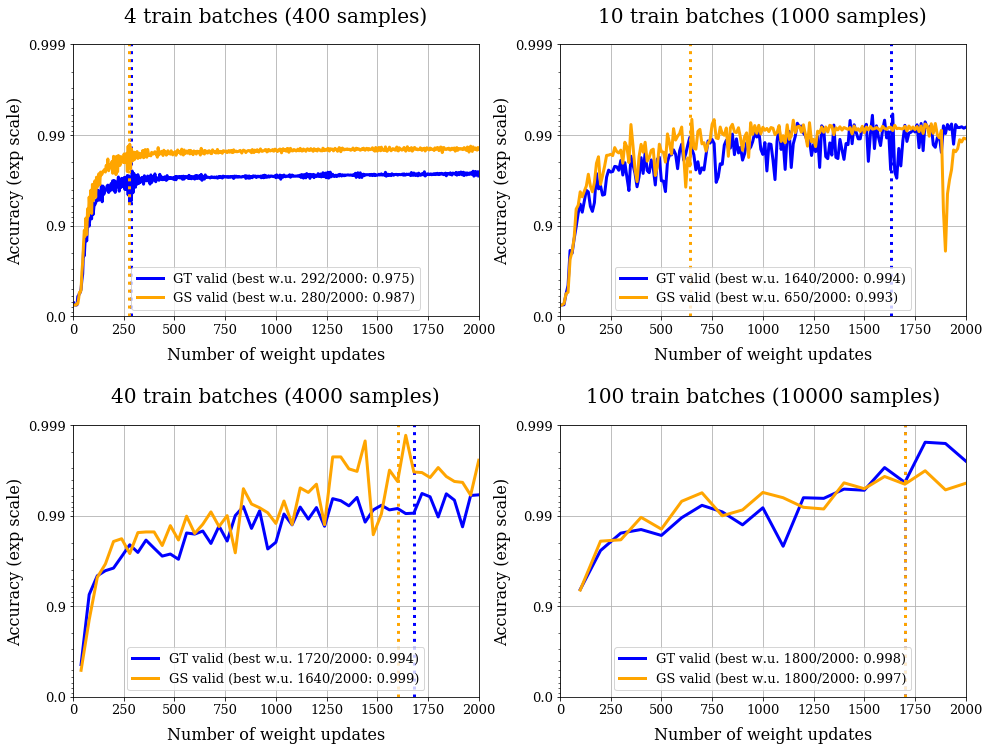

In [47]:
def plot_comparison(grp, tuple_indexer1, tuple_indexer2, weight_updates, 
                    color1='blue', color2='orange', lw1=3, lw2=1.5, 
                    legend_loc='upper center'):
    
    
    epochs = np.max([len(grp.groups[tuple_indexer1]), 
                     len(grp.groups[tuple_indexer2])])
        
    plt.rcParams.update({'font.size': 13})
    plt.title('{} train batches ({} samples)'.format(int(tuple_indexer1[1] / 100), 
                                                     tuple_indexer1[1]), fontsize=20, y=1.06)
    plt.ylabel('Accuracy (exp scale)', fontsize=16)
    plt.xlabel('Number of weight updates', fontsize=16, labelpad=10)
    plt.grid(True)

    s1 = int(tuple_indexer1[1] / 100)
    y1 = np.array(grp.get_group(tuple_indexer1)['val_acc'].values)
    x1 = (np.arange(len(y1)) + 1) * s1
    n1 = name1 = '{} valid (best w.u. {}/{}: {:.3f})'.format(
        tuple_indexer1[0], (np.argmax(y1) + 1) * s1, len(y1) * s1, np.max(y1))
    
    s2 = int(tuple_indexer2[1] / 100)
    y2 = np.array(grp.get_group(tuple_indexer2)['val_acc'].values)
    x2 = (np.arange(len(y2)) + 1) * s2
    n2 = name1 = '{} valid (best w.u. {}/{}: {:.3f})'.format(
        tuple_indexer2[0], (np.argmax(y2) + 1) * s2, len(y2) * s2, np.max(y2))
    
    
    plt.plot(x1, 1 - y1, label=n1, color=color1, linewidth=lw1, linestyle='solid')  # Test
    plt.axvline(np.argmax(y1) * s1, linestyle='dotted', color=color1, linewidth=lw1)
    plt.plot(x2, 1 - y2, label=n2, color=color2, linewidth=lw1, linestyle='solid')  # Test
    plt.axvline(np.argmax(y2) * s2, linestyle='dotted', color=color2, linewidth=lw1)
    
    ##########################
    # Custom exponential scale
    plt.gca().invert_yaxis()
    plt.yscale('log')
    plt.ylim(1, 0.001)
    plt.yticks([0.001, 0.01, 0.1, 1], ['0.999', '0.99', '0.9', '0.0'])
    ##########################
    
    plt.xlim(0, 2000)
    plt.legend(loc=legend_loc)
    return plt
    
    
grp = df.groupby(['rep', 'train_size'])
plt.figure(figsize=(16, 12))

for i, s in enumerate([400, 1000, 4000, 10000]):

    plt.subplot(2,2,i + 1)
    plot_comparison(grp, ('GT', s), ('GS', s), 
                    weight_updates=exp_params['weight_updates'], 
                    legend_loc='lower center')


plt.subplots_adjust(hspace = .40)
plt.savefig('experiments/GT_vs_GS.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Reach plotting after which weight update the model surpassed certain performance threshold - measured by accuracy metric

In the training log, we keep the information about accuracy after each epoch. Each epoch consists of multiple batches. One weight update is done afer each batch. Validation accuracy is measured at the end of each epoch. All models were set to train for 2k weight updates without EarlyStopping callback.

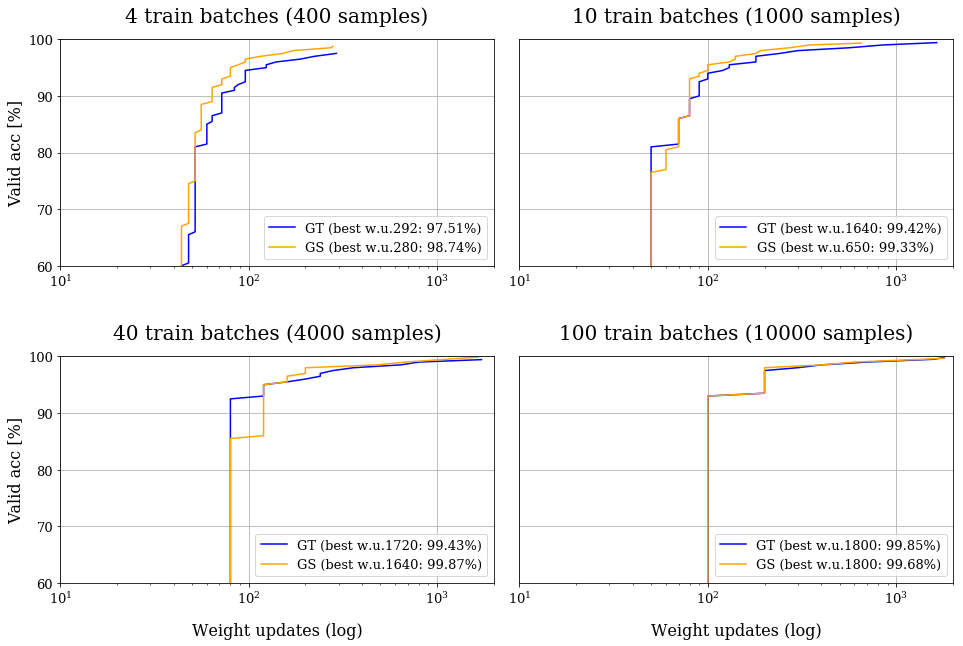

In [81]:
def get_steps(val_acc, steps, weight_updates_per_epoch=1):
    """
    Maps accuracy steps (e.g. [0.5, 0.7, 0.9]) to weight update after which
    the models' accuracy surpassed the aforementioned step.
    """
    dic = {}
    for s in steps:
        try:
            dic[s] = (np.where(val_acc >= s)[0][0] + 1) * weight_updates_per_epoch
        except:
            dic[s] = np.nan
    return dic


# Organize the plot into a grid
grid = plt.GridSpec(2, 6, wspace=0.2, hspace=0.4)
locs = {0: (0, slice(0,3)), 
        1: (0, slice(3,6)), 
        2: (1, slice(0,3)), 
        3: (1, slice(3,6))}

plt.figure(figsize=(16, 10))
sizes = [4, 10, 40, 100]

for i, s in enumerate(sizes):
    # plt.subplot(int(len(sizes))/2,2,i+1)
    plt.subplot(grid[locs[i][0], locs[i][1]])

    for rep, color in zip(['GT', 'GS'], ['blue', 'orange']):
        scores = grp.get_group((rep, s*100))['val_acc']
        steps = np.arange(0.2, 1.0, 0.005)
        best_performance = float(np.max(scores))
        steps = np.sort(list(steps) + [best_performance])
        d = get_steps(scores, 
                      steps=steps, 
                      weight_updates_per_epoch=s)
        
        x = d.values()
        y = d.keys()
        plt.plot(x, y, color=color, label='{} (best w.u.{}: {:.2f}%)'.format(
            rep, 
            list(x)[np.where(np.array(list(y)) == best_performance)[0][0]], 
            best_performance * 100))
    
    plt.rcParams.update({'font.size': 13})
    plt.rcParams["font.family"] = "serif"
    plt.rcParams["mathtext.fontset"] = "dejavuserif"
    yticks = np.arange(0.2, 1.1, 0.1)
    plt.yticks(yticks, (yticks * 100).astype(np.int))
    plt.grid(True)
    plt.xticks([10, 100, 1000])
    plt.xlim(10, 2000)
    plt.xscale('log')
    plt.title('{} train batches ({} samples)'.format(s, s*100), fontsize=20, y=1.05)

    if i in [0, 1]:
        plt.ylim(0.60, 1.0)
    else:
        plt.ylim(0.60, 1.0)
    if i in [0, 2]:
        plt.ylabel('Valid acc [%]', fontsize=16)  #(iterated by  0.5%)
    else:
        plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    if i in [2, 3]:
        plt.xlabel('Weight updates (log)', fontsize=16, labelpad=16)
    plt.legend(loc='lower right')

plt.savefig('experiments/GT_vs_GS_reach.pdf', dpi=100, bbox_inches='tight')
plt.show()
plt.close()

# Cost of computation

In the code bellow, we investigate the time needed for computing the GT and GS using our the Gabor-scattering library, which is our implementation in Python based on Scipy's implementation of STFT.

It is important to say, that all such comparisons are only indicative, because the time is highly dependent on chosen parameters. So the final time is completely dependent on your specific usecase.

With parameters that we have used in this experiment, the mean time necessary to compute the GS is 17.4890ms. The mean time necessary to compute the GT is approx. 3x less, 5.2245ms.

In [103]:
# Measure the time to compute 1000 GT representations of 1s signal sampled at 44,1kHz with given parameters
setup = '''
import numpy as np
from gabor_scattering import gs
wave = np.random.rand(44100)

tfparams = {
    'GT': {
        'l1_params' : {'nfft': 500, 'nperseg': 500, 'noverlap': 250},
        'shapes' : {'outA': (240, 160)},
        'return_outB': False,
        'return_outC': False,
    },
}
'''
GTtime = timeit.timeit("gs(wave, **tfparams['GT'])", number=1000, setup=setup)
print('Total time of computing 1000 GT representations: {:.4f} s.'.format(GTtime))

Total time of computing 1000 GT representations: 5.2245 s.


In [104]:
# Measure the time to compute 1000 GS representations of 1s signal sampled at 44,1kHz with given parameters
setup = '''
import numpy as np
from gabor_scattering import gs
wave = np.random.rand(44100)

tfparams = {
    'GS': {
        'l1_params' : {'nfft': 500, 'nperseg': 500, 'noverlap': 250},
        'l2_params' : {'nfft': 50, 'nperseg': 50, 'noverlap': 40},
        'o2_params' : {'window_len': 5, 'mode': 'same', 'axis':1},
        'shapes' : {'outA': (240, 160), 'outB': (240, 160), 'outC': (240, 160)},
    }
}
'''
GStime = timeit.timeit("gs(wave, **tfparams['GS'])", number=1000, setup=setup)
print('Total time of computing 1000 GS representations: {:.4f} s.'.format(GStime))

Total time of computing 1000 GS representations: 17.4890 s.


In [110]:
# This measurement is of course valid only for this parameter setting. 
print('Computation of Gabor Transform takes approx. {:.0f}% of the time needed to compute Gabor Scattering.'.format((GTtime / GStime)*100))

Computation of Gabor Transform takes approx. 30% of the time needed to compute Gabor Scattering.
